In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. LOAD AND PREPROCESS DATA
data = pd.read_csv("E:\\SEM-2\\AI&ML\\chicagao excel dataset reduced 1.csv")

columns_to_drop = [
    'ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Description',
    'Updated On', 'Location', 'X Coordinate', 'Y Coordinate'
]
data = data.drop(columns=columns_to_drop, errors='ignore')
data = data.fillna(data.mode().iloc[0])

# --------- OUTLIER REMOVAL BASED ON LATITUDE AND LONGITUDE ---------
lat_min, lat_max = 41.6, 42.1
lon_min, lon_max = -87.9, -87.5
if 'Latitude' in data.columns and 'Longitude' in data.columns:
    mask = (
        (data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) &
        (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)
    )
    data = data[mask].copy()

# Save raw coordinates for plotting
data['Latitude_raw'] = data['Latitude']
data['Longitude_raw'] = data['Longitude']

# -------------------------------------------------------------------

# One-hot encode categoricals
categorical_cols = ['Primary Type', 'Location Description']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Convert binary columns
for col in ['Arrest', 'Domestic']:
    if col in data.columns:
        data[col] = data[col].astype(int)

# Scale numeric columns
numeric_cols = ['Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Numeric-only DataFrame for clustering
df_numeric = data.select_dtypes(include=[np.number]).fillna(data.mean(numeric_only=True))

print("Preprocessing complete and outliers removed.")



Preprocessing complete and outliers removed.


In [2]:
# 2. PCA FOR DIMENSIONALITY REDUCTION (before clustering)
n_pca_components = 5
pca = PCA(n_components=n_pca_components)
df_pca = pca.fit_transform(df_numeric)
print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)
print("Total explained variance by first", n_pca_components, "components:", np.sum(pca.explained_variance_ratio_))

# 3. PREPARE SAMPLE FOR GMM FITTING
sample_size = 15000
if len(df_pca) > sample_size:
    idx = np.random.choice(len(df_pca), sample_size, replace=False)
    X_sample = df_pca[idx]
    data_sample = data.iloc[idx].copy()
else:
    X_sample = df_pca.copy()
    data_sample = data.copy()

# 4. GAUSSIAN MIXTURE MODEL (GMM) ON SAMPLE
n_components = 4
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(X_sample)
data_sample['GMM_Cluster'] = gmm_labels

# Silhouette score ON SAMPLE
gmm_sil = silhouette_score(X_sample, gmm_labels)
print(f"GMM Silhouette Score (sample, k={n_components}): {gmm_sil:.4f}")



Explained variance ratio (PCA): [0.54831944 0.13875918 0.11128158 0.07999807 0.05308164]
Total explained variance by first 5 components: 0.9314399274960985
GMM Silhouette Score (sample, k=4): 0.2973


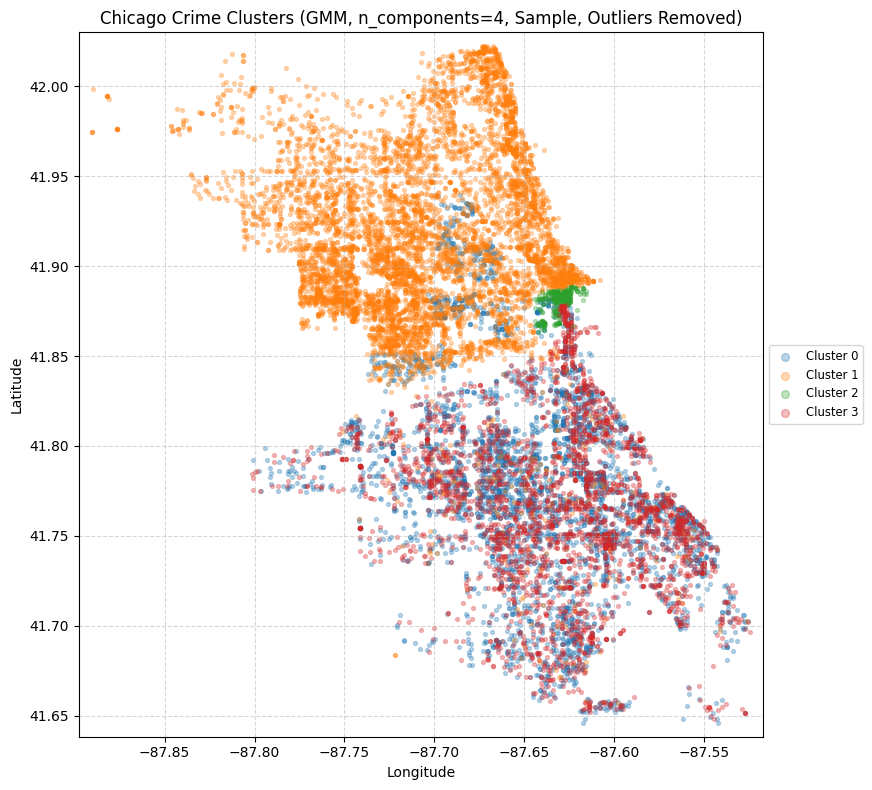

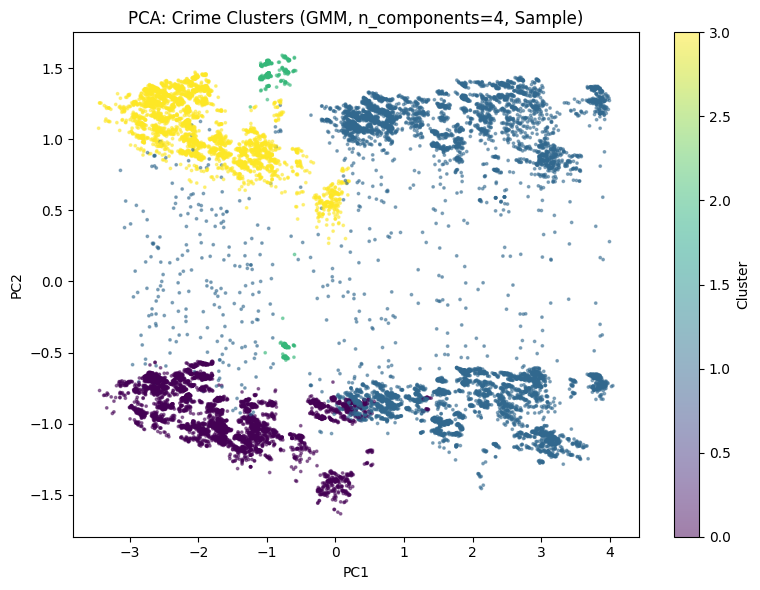

In [3]:
# 5. MAP VISUALIZATION (SAMPLE, using raw coordinates)
plt.figure(figsize=(10, 8))
ax = plt.gca()
for k in sorted(data_sample['GMM_Cluster'].unique()):
    subset = data_sample[data_sample['GMM_Cluster'] == k]
    plt.scatter(subset['Longitude_raw'], subset['Latitude_raw'], label=f"Cluster {k}", alpha=0.3, s=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Chicago Crime Clusters (GMM, n_components={n_components}, Sample, Outliers Removed)")
plt.grid(True, linestyle='--', alpha=0.5)

lon_min, lon_max = data_sample['Longitude_raw'].min(), data_sample['Longitude_raw'].max()
lat_min, lat_max = data_sample['Latitude_raw'].min(), data_sample['Latitude_raw'].max()
lon_buffer = (lon_max - lon_min) * 0.02
lat_buffer = (lat_max - lat_min) * 0.02
plt.xlim(lon_min - lon_buffer, lon_max + lon_buffer)
plt.ylim(lat_min - lat_buffer, lat_max + lat_buffer)
ax.set_aspect('equal', adjustable='box')
plt.legend(markerscale=2, fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 6. PCA VISUALIZATION (SAMPLE)
pca2 = PCA(n_components=2)
pca_components = pca2.fit_transform(X_sample)
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=gmm_labels, cmap='viridis', alpha=0.5, s=3)
plt.title(f"PCA: Crime Clusters (GMM, n_components={n_components}, Sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()



In [4]:
# 7. CLUSTER PROFILING (SAMPLE)
def cluster_insight_table(data_sample, cluster_col='GMM_Cluster'):
    # Get cluster sizes
    cluster_sizes = data_sample[cluster_col].value_counts().sort_index()
    # Get arrest rates
    arrest_rates = data_sample.groupby(cluster_col)['Arrest'].mean()
    # Get domestic rates
    domestic_rates = data_sample.groupby(cluster_col)['Domestic'].mean()
    # Most common crime type (if present)
    if 'Primary Type' in data_sample.columns:
        top_crime = data_sample.groupby(cluster_col)['Primary Type'].agg(lambda x: x.value_counts().index[0])
    else:
        top_crime = pd.Series('-', index=cluster_sizes.index)
    # Build summary DataFrame
    summary = pd.DataFrame({
        'Size': cluster_sizes,
        'Arrest Rate': arrest_rates,
        'Domestic Rate': domestic_rates,
        'Top Crime Type': top_crime
    })
    def make_insight(row):
        if row['Size'] < 10:
            return "Tiny cluster: may be rare or special-case events"
        elif row['Arrest Rate'] > 0.8:
            return "Very high arrest rate"
        elif row['Arrest Rate'] < 0.05:
            return "Very low arrest rate"
        elif row['Domestic Rate'] > 0.7:
            return "Mostly domestic incidents"
        elif row['Domestic Rate'] < 0.05:
            return "Rarely domestic incidents"
        else:
            return "Typical cluster"
    summary['Insight'] = summary.apply(make_insight, axis=1)
    return summary

table = cluster_insight_table(data_sample, cluster_col='GMM_Cluster')
print(table)

for k in sorted(data_sample['GMM_Cluster'].unique()):
    print(f"\n--- GMM Cluster {k} ---")
    if 'Primary Type' in data_sample.columns:
        print(data_sample[data_sample['GMM_Cluster'] == k]['Primary Type'].value_counts().head(5))
    print("Arrest Rate:", data_sample[data_sample['GMM_Cluster'] == k]['Arrest'].mean())

# 8. GMM ON FULL DATA
gmm_full = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels_full = gmm_full.fit_predict(df_pca)
data['GMM_Cluster'] = gmm_labels_full

# Silhouette score on full data
gmm_full_sil = silhouette_score(df_pca, gmm_labels_full)
print(f"GMM Silhouette Score (FULL DATA, k={n_components}): {gmm_full_sil:.4f}")

             Size  Arrest Rate  Domestic Rate Top Crime Type  \
GMM_Cluster                                                    
0            4413     0.262633       0.203263              -   
1            7310     0.225308       0.143776              -   
2             350     0.234286       0.045714              -   
3            2927     0.113427       0.221045              -   

                               Insight  
GMM_Cluster                             
0                      Typical cluster  
1                      Typical cluster  
2            Rarely domestic incidents  
3                      Typical cluster  

--- GMM Cluster 0 ---
Arrest Rate: 0.26263312939043737

--- GMM Cluster 1 ---
Arrest Rate: 0.2253077975376197

--- GMM Cluster 2 ---
Arrest Rate: 0.2342857142857143

--- GMM Cluster 3 ---
Arrest Rate: 0.1134267167748548
GMM Silhouette Score (FULL DATA, k=4): 0.2307
